# Simulación en grafos de mayor tamaño

Utilizando los *drivings* óptimos encontrados, se ha ejecutado la simulación para nuevos conjuntos de grafos de 1000 instancias cada una. Los grafos de cada conjunto tiene un número de nodos diferente. En total, se han simulado los resultados para grafos de 7,8,9,10,11,12,13,14,15,17,19,21,23, y 25 nodos. Las simulaciones se realizaron en el servidor LluisVives, y se descargaron los resultados, los cuales se encuentran en la carpeta data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.lines import Line2D
import seaborn as sns
import glob
import random
import networkx as nx
import imageio.v2 as imageio
import os

from src.aitor_utils import Graph_gen, plot_espectro, get_blockade_configurations2, C_from_gr

# Observar resultados por tamaño de grafo

Histograma de AR para un conjunto de grafos

In [2]:
n_nodos = 25 # Elegir el número de nodos desesado

try:
    df = pd.read_csv(f'data/simul_{n_nodos}_nodos.csv')
except FileNotFoundError:
    print(f'No se he hecho el estudio para {n_nodos} nodos')
    print('Prueba con: 7,8,9,10,11,12,13,14,15,17,19,21,23, o 25')
df.head()

,n_nodos,atoms_w,atoms_l,seed,p_0,p_1,e_gap,e_0,e_1,succ,ar,hp
0,25,7,6,2,0.99180,0.00750,0.1132,-6.0826,-5.9694,0.99180,0.999797,1.062816
1,25,7,6,3,0.93140,0.06555,0.0630,-5.5703,-5.5073,0.00015,0.988394,1.579243
2,25,7,6,4,0.97415,0.01320,0.1046,-6.3907,-6.2861,0.97415,0.999203,1.106196
3,25,7,6,5,0.84045,0.15070,0.0238,-6.0707,-6.0469,0.15070,0.996063,1.870588
4,25,7,6,6,0.97355,0.02225,0.0054,-6.6837,-6.6783,0.97355,0.999660,1.993096


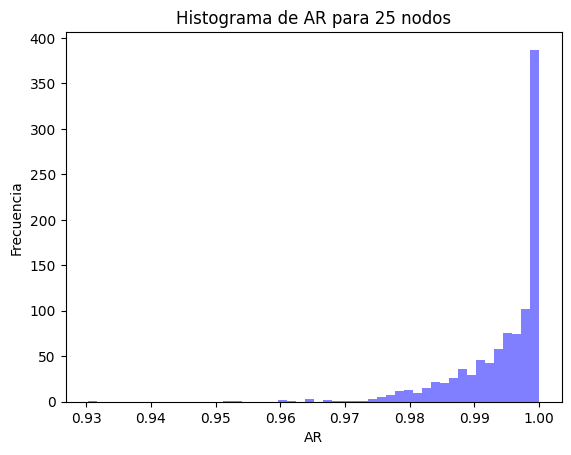

In [3]:
plt.hist(df.ar, bins=50, alpha=0.5, color='blue', label='AR')
plt.xlabel('AR')
plt.ylabel('Frecuencia')
plt.title(f'Histograma de AR para {n_nodos} nodos')
plt.show()

SP y AR frente al *gap* para conjuntos de grafos de entre 7 y 25 nodos.

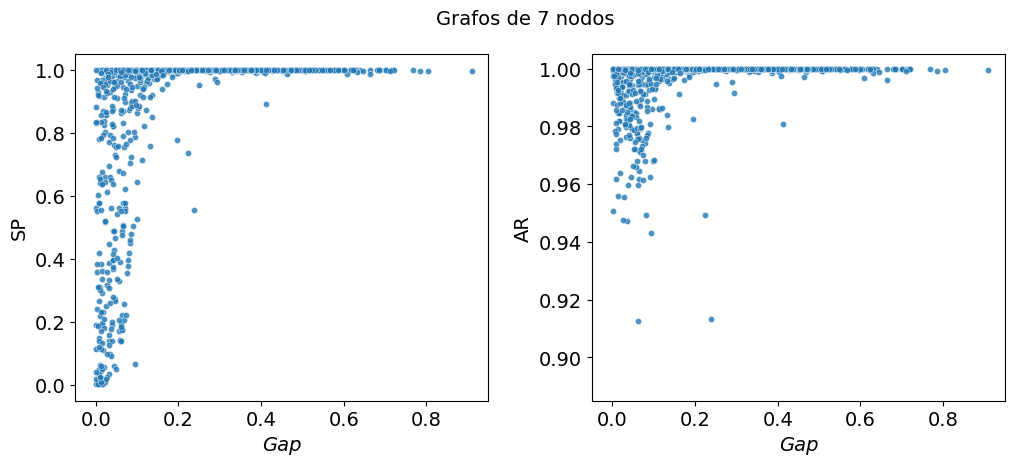

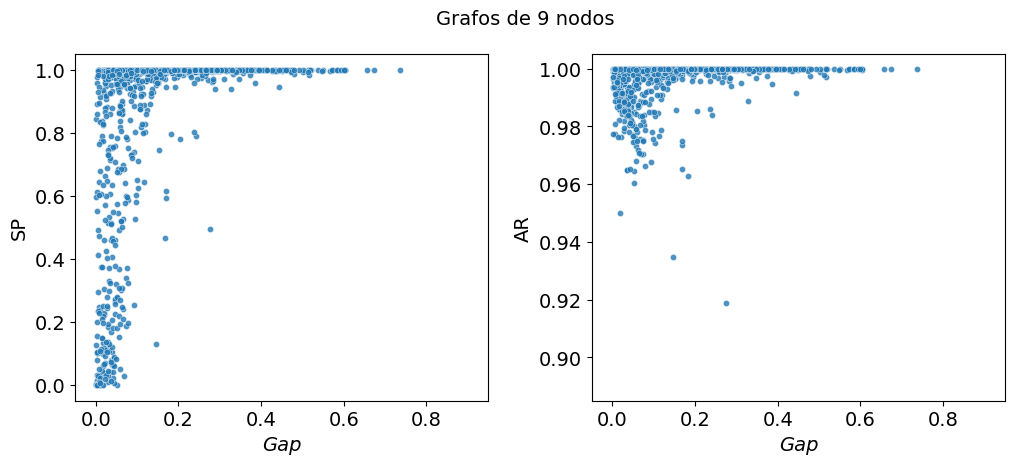

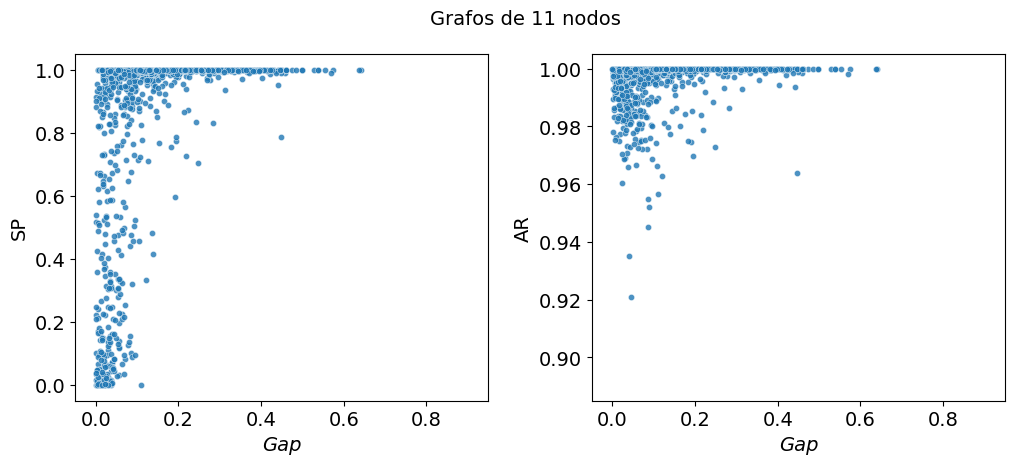

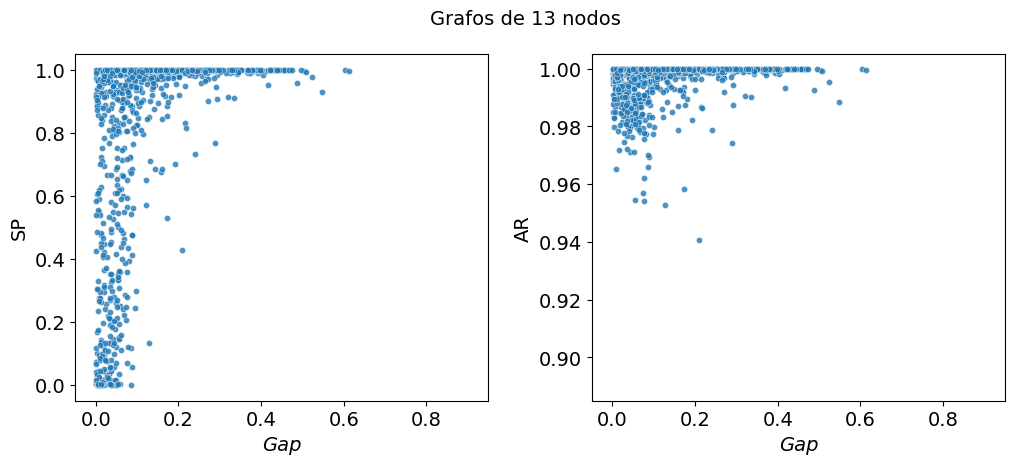

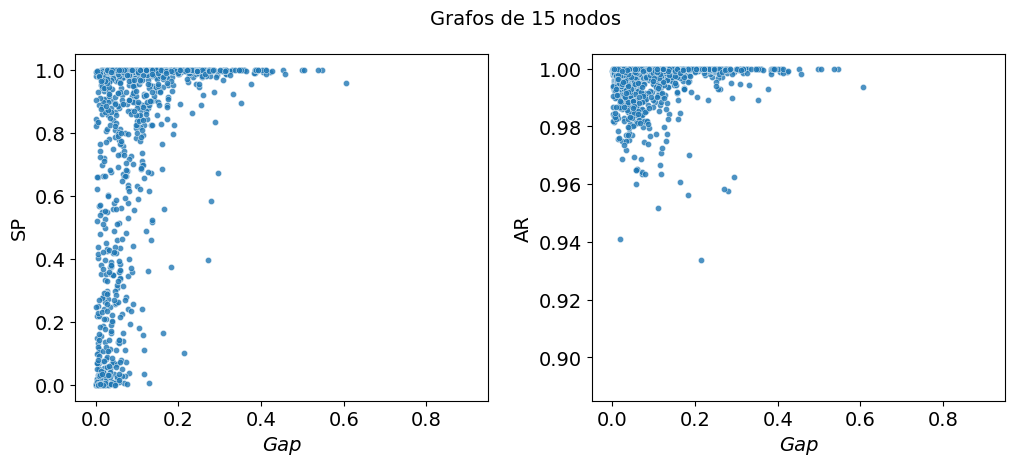

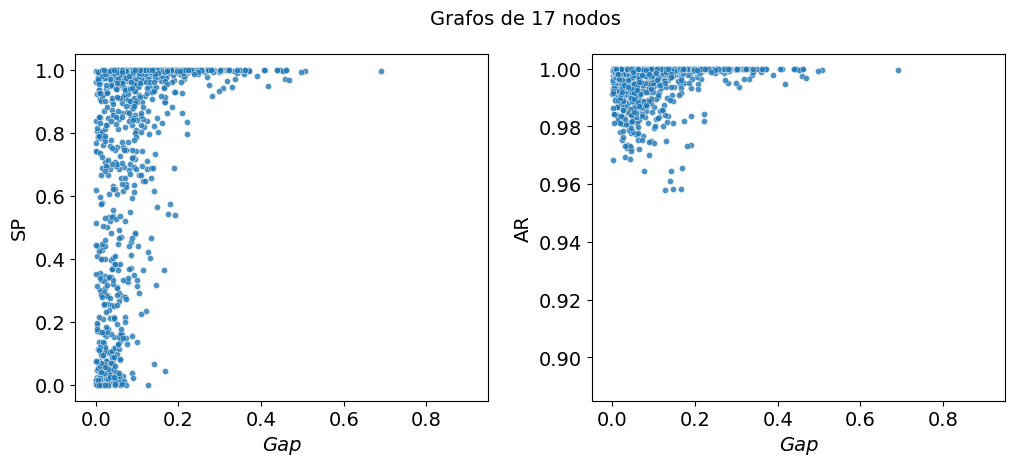

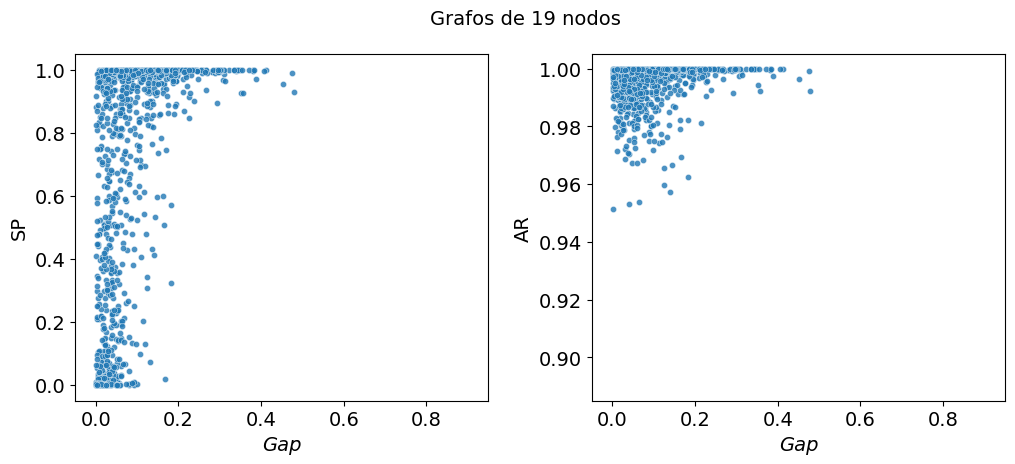

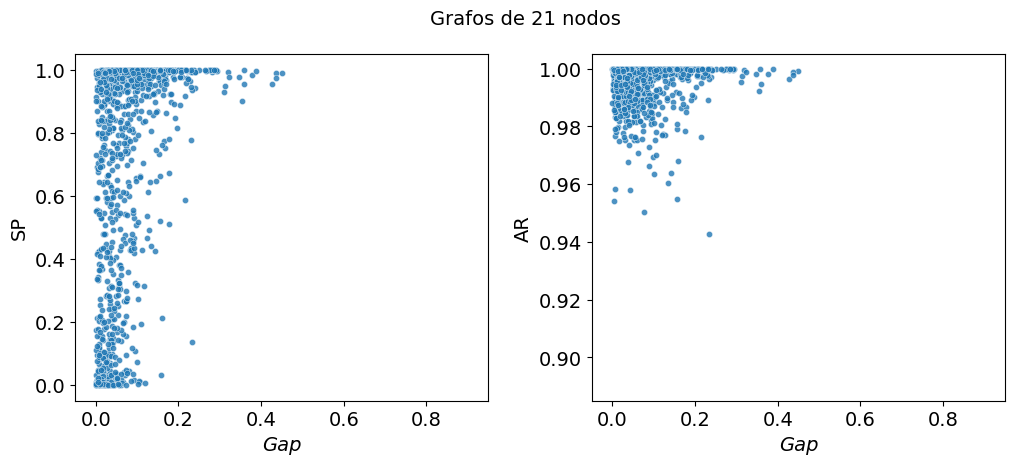

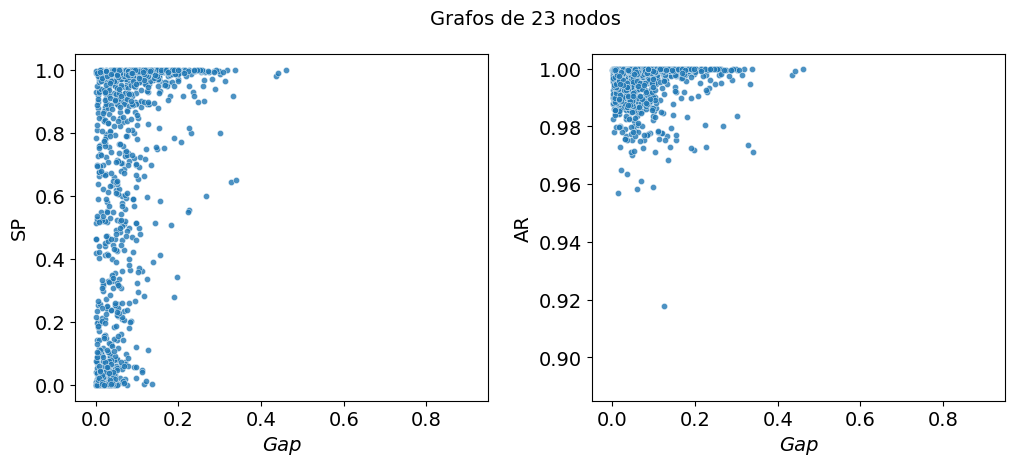

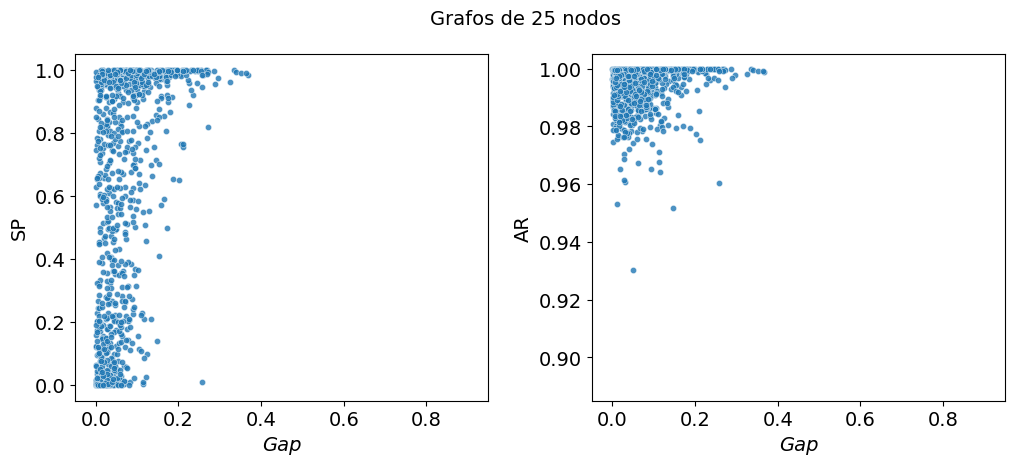

In [ ]:
nodos = [7,9,11,13,15,17,19,21,23,25]

for n in nodos:
    df = pd.read_csv(f'data/simul_{n}_nodos.csv')

    fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # 1 fila, 2 columnas
    plt.suptitle(f'Grafos de {n} nodos', fontsize=14)

    # Primer gráfico en el primer eje
    sns.scatterplot(data=df, x='e_gap', y='succ', s=20, alpha=0.8, ax=axes[0])

    # Segundo gráfico en el segundo eje
    sns.scatterplot(data=df, x='e_gap', y='ar', s=20, alpha=0.8, ax=axes[1])
    # Ajustar layout
    plt.subplots_adjust(wspace=0.25) 
    axes[0].set_xlabel('Gap', fontsize=14, style='italic')
    axes[0].set_ylabel('SP', fontsize=14)
    axes[0].tick_params(axis='both', labelsize=14)
    axes[0].set_ylim(-0.05, 1.05)
    axes[0].set_xlim(-0.05, 0.95)

    axes[1].set_xlabel('Gap', fontsize=14, style='italic')
    axes[1].set_ylabel('AR', fontsize=14)
    axes[1].tick_params(axis='both', labelsize=14)
    axes[1].set_ylim(0.885, 1.005)
    axes[1].set_xlim(-0.05, 0.95)
    plt.savefig(f'SP_AR_e_gap/{n}_nodos.png', dpi=300, bbox_inches='tight')

Generar un GIF con los plots de arriba

In [ ]:
# Ruta donde guardaste las imágenes
image_folder = 'SP_AR_e_gap'
output_gif = 'grafos_animacion.gif'

# Lista de nodos en orden
nodos = [7,8,9,10,11,12,13,14,15,17,19,21,23,25]

# Crear la lista de archivos de imagen
image_files = [f"{image_folder}/{n}_nodos.png" for n in nodos]

# Crear el GIF
with imageio.get_writer(output_gif, mode='I', duration=0.05) as writer:
    for filename in image_files:
        image = imageio.imread(filename)
        writer.append_data(image)

print("GIF creado exitosamente.")


Mostrar el espectro de un grafo aleatorio de uno de los conjuntos de grafo

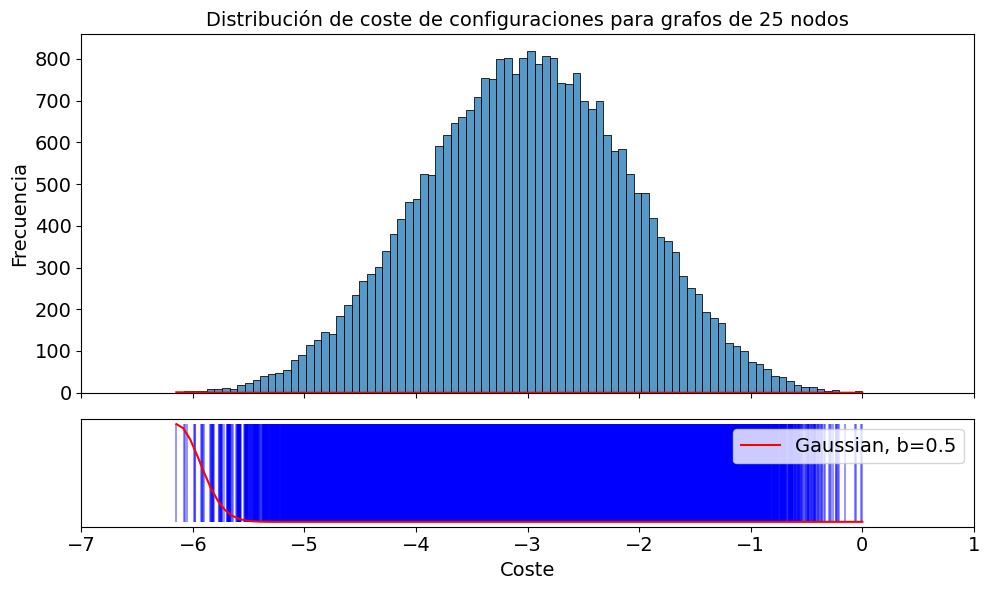

In [ ]:
n_nodos = 25 # Elegir el número de nodos desesado

try:
    df = pd.read_csv(f'data/simul_{n_nodos}_nodos.csv')
except FileNotFoundError:
    print(f'No se he hecho el estudio para {n_nodos} nodos')
    print('Prueba con: 7,8,9,10,11,12,13,14,15,17,19,21,23, o 25')

indice = random.randint(0, 999)
np.random.seed(int(df.iloc[indice].seed))
n_nodos = int(df.iloc[indice].n_nodos)
atoms_w = int(df.iloc[indice].atoms_w)
atoms_l = int(df.iloc[indice].atoms_l)
scale = 5e-6
G, register = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

# Dibujar el grafo
pos = nx.get_node_attributes(G, 'pos')
weight = nx.get_node_attributes(G, 'weight').values()
posiciones = np.array(list(pos.values()))

# plt.title(f'Grafo con {n_nodos} nodos, malla de {atoms_w}x{atoms_l} y semilla {int(df.iloc[indice].seed)}')
# nx.draw(G, pos, with_labels=True, node_size=[v*1000 for v in weight], node_color='skyblue')
# plt.show()

# Calcular el espectro del grafo
conf = get_blockade_configurations2(posiciones, 7.2e-6)
espectro = pd.DataFrame(conf, columns=['bitstring'])
espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, list(weight), G.nodes()))
espectro = espectro.sort_values('energia', ascending=True)

plot_espectro(espectro)


In [ ]:
n_nodos = 7 # Elegir el número de nodos desesado

try:
    df = pd.read_csv(f'data/simul_{n_nodos}_nodos.csv')
except FileNotFoundError:
    print(f'No se he hecho el estudio para {n_nodos} nodos')
    print('Prueba con: 7,8,9,10,11,12,13,14,15,17,19,21,23, o 25')

indice = random.randint(0, 999)
np.random.seed(int(df.iloc[indice].seed))
n_nodos = int(df.iloc[indice].n_nodos)
atoms_w = int(df.iloc[indice].atoms_w)
atoms_l = int(df.iloc[indice].atoms_l)
scale = 5e-6
G, register = Graph_gen(n_nodos, atoms_w, atoms_l, scale)

# Dibujar el grafo
pos = nx.get_node_attributes(G, 'pos')
weight = nx.get_node_attributes(G, 'weight').values()
posiciones = np.array(list(pos.values()))

# plt.title(f'Grafo con {n_nodos} nodos, malla de {atoms_w}x{atoms_l} y semilla {int(df.iloc[indice].seed)}')
# nx.draw(G, pos, with_labels=True, node_size=[v*1000 for v in weight], node_color='skyblue')
# plt.show()

# Calcular el espectro del grafo
conf = get_blockade_configurations2(posiciones, 7.2e-6)
espectro = pd.DataFrame(conf, columns=['bitstring'])
espectro['energia'] = espectro['bitstring'].apply(lambda x: C_from_gr(x, list(weight), G.nodes()))
espectro = espectro.sort_values('energia', ascending=True)

plot_espectro(espectro)


# Resultados en función del número de nodos

En este apartado se muestra cómo varian diferentes variables en función del número de nodos.

In [ ]:
# Unir todos los dataframes en uno solo
csv_files = glob.glob("data/simul_*.csv")
dfc = pd.DataFrame(columns=df.columns)
for file in csv_files:
    df = pd.read_csv(file)
    dfc = pd.concat([dfc, df], ignore_index=True)

nodos_faltantes = [16, 18, 20, 22, 24]
# Crear un nuevo DataFrame con las mismas columnas que df, todo a NaN
df_extra = pd.DataFrame(np.nan, index=range(len(nodos_faltantes)), columns=df.columns)

# Asignar los nuevos valores a la columna 'n_nodos'
df_extra['n_nodos'] = nodos_faltantes

# Concatenar ambos DataFrames
dfc = pd.concat([dfc, df_extra], ignore_index=True)

C:\Users\aitoo\AppData\Local\Temp\ipykernel_5372\1417110910.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfc = pd.concat([dfc, df], ignore_index=True)


In [16]:
dfc_resumen = dfc.groupby('n_nodos').agg({f'{variable}': 'mean' for variable in dfc.columns})

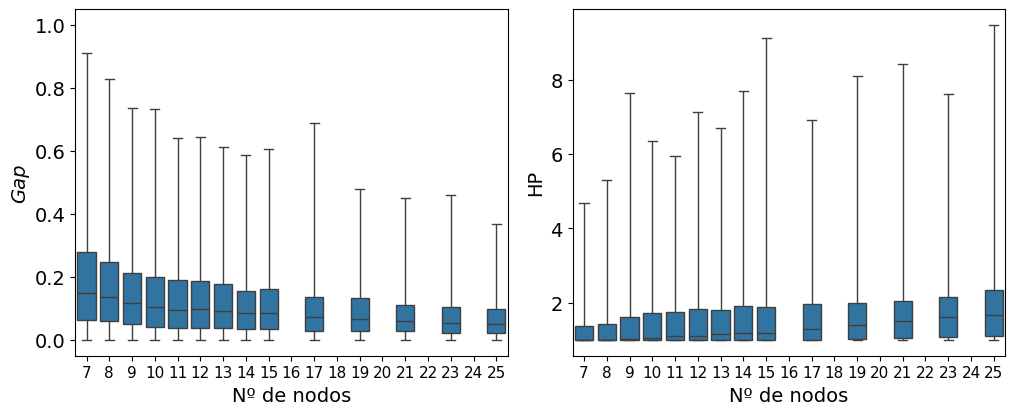

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # 1 fila, 2 columnas

# Primer gráfico en el primer eje
sns.boxplot(x='n_nodos', y='e_gap', data=dfc, whis=100, ax=axes[0])# Segundo gráfico en el segundo eje
sns.boxplot(x='n_nodos', y='hp', data=dfc, whis=1000, ax=axes[1])# Ajustar layout
plt.subplots_adjust(wspace=0.15) 
axes[0].set_xlabel('Nº de nodos', fontsize=14)
axes[0].set_ylabel('Gap', fontsize=14, style='italic')
axes[0].tick_params(axis='y', labelsize=14)
axes[0].tick_params(axis='x', labelsize=11)
axes[0].set_ylim(-0.05, 1.05)
axes[1].set_xlabel('Nº de nodos', fontsize=14)
axes[1].set_ylabel('HP', fontsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].tick_params(axis='x', labelsize=11)
# axes[1].set_ylim(0.885, 1.005)
plt.show()

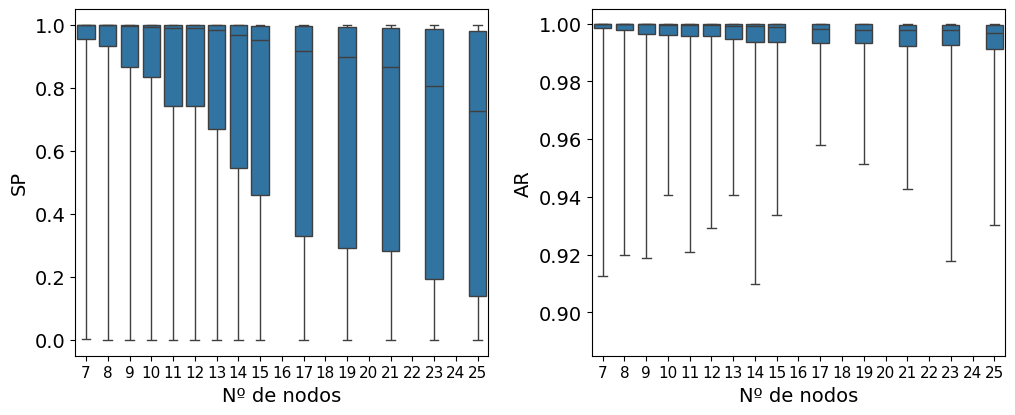

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4.5))  # 1 fila, 2 columnas

# Primer gráfico en el primer eje
sns.boxplot(x='n_nodos', y='succ', data=dfc, whis=1000, ax=axes[0])
# Segundo gráfico en el segundo eje
sns.boxplot(x='n_nodos', y='ar', data=dfc, whis=1000, ax=axes[1])# Ajustar layout
plt.subplots_adjust(wspace=0.25) 
axes[0].set_xlabel('Nº de nodos', fontsize=14)
axes[0].set_ylabel('SP', fontsize=14)
axes[0].tick_params(axis='y', labelsize=14)
axes[0].tick_params(axis='x', labelsize=11)
axes[0].set_ylim(-0.05, 1.05)
axes[1].set_xlabel('Nº de nodos', fontsize=14)
axes[1].set_ylabel('AR', fontsize=14)
axes[1].tick_params(axis='y', labelsize=14)
axes[1].tick_params(axis='x', labelsize=11)
axes[1].set_ylim(0.885, 1.005)
plt.show()

# Estudio de AR para diferentes valores de gap y n_nodos

In [37]:
dfc['e_gap_redondeado'] = dfc['e_gap'].round(2)


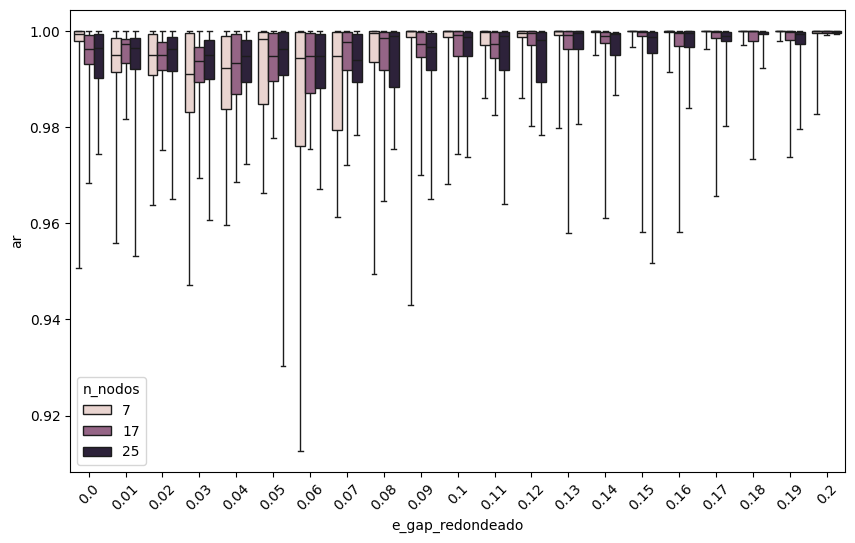

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=dfc[((dfc.n_nodos == 17) | (dfc.n_nodos == 7) | (dfc.n_nodos > 23)) & (dfc.e_gap < 0.2)], x='e_gap_redondeado', y='ar', hue='n_nodos', whis=100)
plt.xticks(rotation=45)
plt.show()

C:\Users\aitoo\AppData\Local\Temp\ipykernel_15152\65617300.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('rainbow', dfc.n_nodos.nunique())
C:\Users\aitoo\AppData\Local\Temp\ipykernel_15152\65617300.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  promedios = dfc_n.groupby('e_gap_interval').ar.mean()


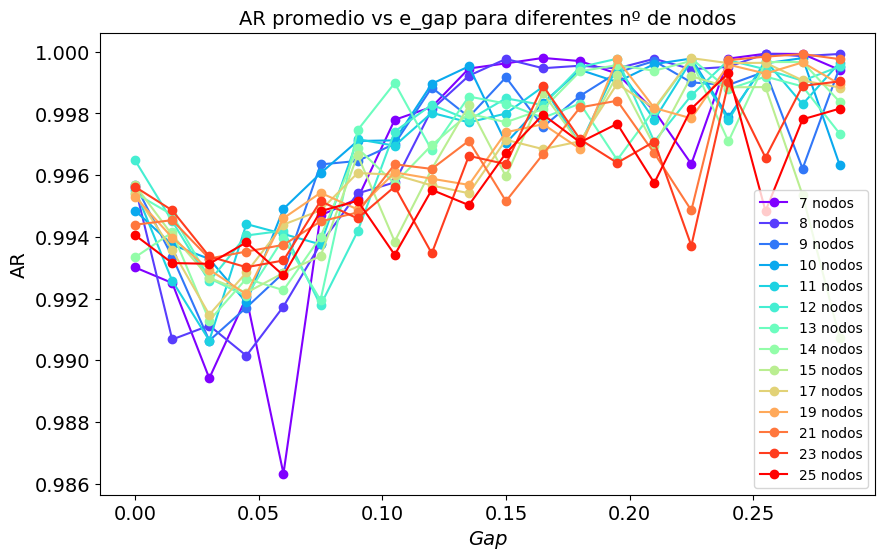

In [ ]:
bins = np.linspace(0, 0.3, 21) # Intervalos que se van a usar para el histograma

labels = [bins[i] for i in range(len(bins)-1)]

dfc['e_gap_interval'] = pd.cut(dfc['e_gap'], bins=bins, labels=labels, include_lowest=True)
colors = cm.get_cmap('rainbow', dfc.n_nodos.nunique())

plt.figure(figsize=(10, 6))
for i, n in enumerate(np.sort(dfc.n_nodos.unique())):
    dfc_n = dfc[dfc.n_nodos == n]
    promedios = dfc_n.groupby('e_gap_interval').ar.mean()
    promedios = promedios.dropna()
    plt.plot(promedios, '-o', label=f'{n} nodos', color=colors(i/len(dfc.n_nodos.unique())))


plt.legend()
plt.xlabel('Gap', fontsize=14, style='italic')
plt.ylabel('AR', fontsize=14)
plt.title('AR promedio vs e_gap para diferentes nº de nodos', fontsize=14)

plt.tick_params(axis='both', labelsize=14)

plt.show()


C:\Users\aitoo\AppData\Local\Temp\ipykernel_18924\1847430171.py:35: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('rainbow', len(nodos_mostrados))


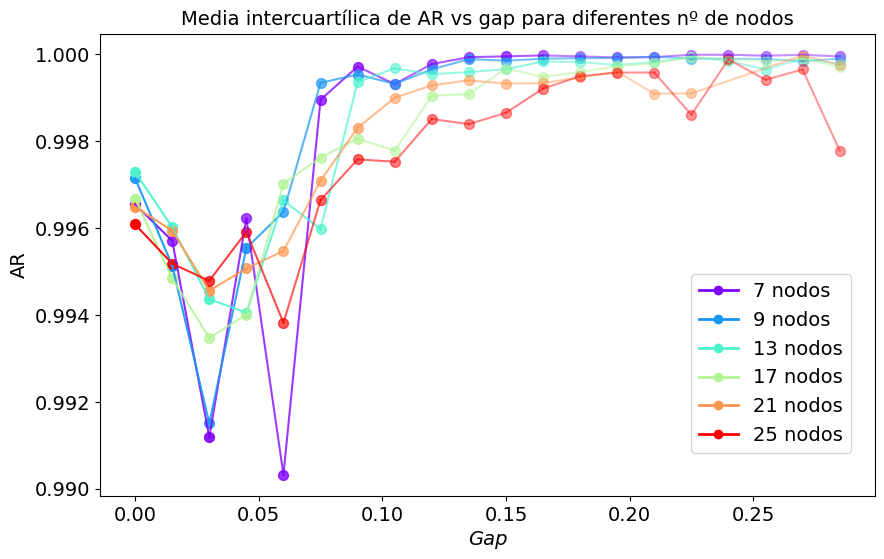

In [ ]:
def media_iqr_columna(grupo: pd.DataFrame) -> float:
    """
    Calcula la media de los valores dentro del rango intercuartílico (IQR) para una columna específica en un grupo.
    
    Parámetros:
    - grupo: DataFrame agrupado (una parte del groupby).
    - columna: nombre de la columna sobre la que aplicar el cálculo.
    
    Devuelve:
    - Un valor float con la media de los valores dentro del IQR del grupo.
    """
    valores = grupo.dropna()
    q1 = np.percentile(valores, 25)
    q3 = np.percentile(valores, 75)
    iqr_mask = (valores >= q1) & (valores <= q3)
    return valores[iqr_mask].mean() if any(iqr_mask) else np.nan



primer_trozo = np.linspace(0, 0.3, 21)
bins = primer_trozo
labels = [bins[i] for i in range(len(bins) - 1)]

dfc['e_gap_interval'] = pd.cut(dfc['e_gap'], bins=bins, labels=labels, include_lowest=True)


nodos_mostrados = [7, 9, 13, 17, 21, 25] # np.sort(dfc.n_nodos.unique())
colors = cm.get_cmap('rainbow', len(nodos_mostrados))

plt.figure(figsize=(10, 6))
for i, n in enumerate(nodos_mostrados): 
    dfc_n = dfc[dfc.n_nodos == n]

    grouped = dfc_n.groupby('e_gap_interval', observed=True)['ar']
    promedios = grouped.mean().dropna()
    counts = grouped.count().loc[promedios.index]
    

    promedios = grouped.apply(media_iqr_columna)
    # print('n_nodos:',n,grouped.min())

    min_alpha, max_alpha = 0.4, 1.0
    counts_norm = (counts - counts.min()) / (counts.max() - counts.min())
    alphas = min_alpha + counts_norm * (max_alpha - min_alpha)
    x_vals = np.array([float(str(lbl)) for lbl in promedios.index])  # convertir bin labels a float
    y_vals = promedios.values

    # Dibujar segmentos con opacidad variable
    for j in range(len(x_vals) - 1):
        if np.isnan(y_vals[j + 1]):
            sigue_nan = True
            p = j + 1
            while sigue_nan:
                if (p < len(x_vals)) and not (np.isnan(y_vals[p + 1])):
                    sigue_nan = False
                    y_seg = [y_vals[j], y_vals[p + 1]]
                    x_seg = [x_vals[j], x_vals[p + 1]]
                p += 1
        else:
            y_seg = [y_vals[j], y_vals[j + 1]]
            x_seg = [x_vals[j], x_vals[j + 1]]
        alpha_seg = (alphas.iloc[j] + alphas.iloc[j + 1]) / 2  # media entre dos alphas
        plt.plot(x_seg, y_seg, color=colors(i / len(nodos_mostrados)), alpha=alpha_seg)

    # Dibujar puntos con su alpha correspondiente
    for x, y, a in zip(x_vals, y_vals, alphas):
        plt.scatter(x, y, color=colors(i / len(nodos_mostrados)), alpha=a, s=50)

# Crear handles de leyenda personalizados
legend_handles = [
    Line2D(
        [0], [0],
        color=colors(i / len(nodos_mostrados)),
        marker='o',
        linestyle='-',
        linewidth=2,
        markersize=6,
        label=f'{n} nodos',
        alpha=1.0
    )
    for i, n in enumerate(nodos_mostrados)
]

plt.legend(handles=legend_handles, bbox_to_anchor=(0.75, 0.5), loc='upper left', fontsize=14)
plt.xlabel('Gap', fontsize=14, style='italic')
plt.ylabel('AR', fontsize=14)
plt.title('Media intercuartílica de AR vs gap para diferentes nº de nodos', fontsize=14)
plt.tick_params(axis='both', labelsize=14)
plt.show()


Calcular el ratio de instancias que tienen un AR>0.99

In [ ]:
# Se resta 5 a la longitud para evitar contar los valores NaN al final que se han añadido manualmente
len(dfc.loc[dfc.ar > 0.99])/(len(dfc)-5)

0.8463571428571428